<a href="https://colab.research.google.com/github/cxbxmxcx/EvolutionaryDeepLearning/blob/main/EDL_9_4_DCGAN_Encoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install livelossplot --quiet

In [ ]:
#@title The Imports
from tensorflow.keras.datasets import mnist as data
#from tensorflow.keras.datasets import fashion_mnist as data
#from tensorflow.keras.datasets import cifar10 as data

#from tensorflow.keras.utils import np_utils
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Input, Dense, Activation, Flatten, Reshape, Dropout, ZeroPadding2D
from tensorflow.keras.layers import Conv2D, Conv2DTranspose, UpSampling2D, Convolution2D
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.optimizers import Adam, RMSprop
from tensorflow.keras.initializers import RandomNormal

import tensorflow.keras.backend as K

import numpy as np
import matplotlib.pyplot as plt
from livelossplot import PlotLosses
from tqdm import tqdm_notebook

import random
from tqdm.notebook import tqdm as tqdm
plt.gray()

<Figure size 432x288 with 0 Axes>

In [ ]:
#@title Extract Class of Images
def extract(images, labels, class_):  
  labels = np.squeeze(labels)  
  idx = labels == class_  
  imgs = images[idx]
  print(imgs.shape)
  return imgs

11501568/11490434 [==============================] - 0s 0us/step
(60000, 28, 28)
(5421, 28, 28)
(5421, 28, 28, 1)


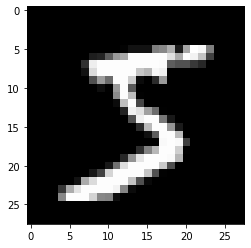

In [ ]:
#@title Load and Normalize Training/Test Data
(train_images, train_labels), (test_images, test_labels) = data.load_data()

# split dataset
#train_images = train_images.reshape(train_images.shape[0], 28, 28, 1).astype("float32") / 255.0
print(train_images.shape)

train_images = extract(train_images, train_labels, 5)
plt.imshow(train_images[0])

# Rescale -1 to 1
train_images = (train_images.astype(np.float32) - 127.5) / 127.5
if len(train_images.shape)<4:
  train_images = np.expand_dims(train_images, axis=3)
print(train_images.shape)

In [ ]:
#@title Determine Global Parameters
latent_dim = 100
channels = train_images.shape[3]
image_shape = (train_images.shape[1], train_images.shape[2], channels)
print(image_shape)

(28, 28, 1)


In [ ]:
#@title Range Helper Functions
def clamp(num, min_value, max_value):
   return max(min(num, max_value), min_value)

def linespace(v, min, max):
  range = max - min 
  return v * range + min

def linespace_int(v, min, max):
  range = max - min
  return int(v * range + min)

def reverse_space(x, min, max):
  range = max - min
  if range==0: return 0
  return (x - min) / range

In [ ]:
#@title Defining the DCGAN Class

# ENCODING CONSTANTS
FILTERS = 0
MIN_FILTERS = 16
MAX_FILTERS = 128
ALPHA = 1
MIN_ALPHA = .05
MAX_ALPHA = .5
CRITICS = 2
MIN_CRITICS = 1
MAX_CRITICS = 10
CLIP = 3
MIN_CLIP = .005
MAX_CLIP = .1
LR = 4
MIN_LR = .00000001
MAX_LR = .0001

class DCGAN:
  def __init__(self, i):  
    '''
    === GLOBAL ===
    image_shape=(32, 32, 1),
    z_size=(1, 1, latent_dim),
    === ENCODED ===
    n_filters=128,    
    alpha=0.2,
    disc_iters=5         
    clip_lower=-0.01,                
    clip_upper=0.01, 
    lr=5e-5, 
    '''
    assert image_shape[0] % 4 == 0, "Image shape must be divisible by 4."

    self.image_shape = image_shape
    self.z_size = (1, 1, latent_dim)

    self.n_filters = linespace_int(i[FILTERS], MIN_FILTERS, MAX_FILTERS)    
    self.alpha = linespace_int(i[ALPHA], MIN_ALPHA, MAX_ALPHA)
    self.lr = linespace(i[LR], MIN_LR, MAX_LR)   
    self.clip_lower = -linespace(i[CLIP], MIN_CLIP, MAX_CLIP)
    self.clip_upper = linespace(i[CLIP], MIN_CLIP, MAX_CLIP)
    self.critic_iters = linespace_int(i[CRITICS], MAX_CRITICS, MIN_CRITICS)
    self.weight_init = RandomNormal(mean=0., stddev=0.02)
    self.optimizer = RMSprop(self.lr)

    self.critic = self.build_critic()    
    self.g = self.build_generator()
    self.gan = self.build_gan()    

  def build_critic(self):
    model = Sequential(name="Critic")    
    model.add(Conv2D(self.n_filters//4, kernel_size=3, strides=2, input_shape=self.image_shape, padding="same"))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(self.n_filters//2, kernel_size=3, strides=2, padding="same"))
    model.add(ZeroPadding2D(padding=((0,1),(0,1))))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(self.n_filters, kernel_size=3, strides=2, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Conv2D(self.n_filters*2, kernel_size=3, strides=1, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(LeakyReLU(alpha=0.2))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(1))

    img = Input(shape=self.image_shape)
    validity = model(img)
    model = Model(img, validity)
    model.compile(loss=self.wasserstein_loss,
            optimizer=self.optimizer,
            metrics=['accuracy'])

    return model

  def build_generator(self):
    model = Sequential(name="Generator")    
    cs = self.image_shape[1] // 4

    model.add(Dense(self.n_filters * cs * cs, activation="relu", input_dim=latent_dim))
    model.add(Reshape((cs, cs, self.n_filters)))
    model.add(UpSampling2D())
    model.add(Conv2D(self.n_filters, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(UpSampling2D())
    model.add(Conv2D(self.n_filters//2, kernel_size=3, padding="same"))
    model.add(BatchNormalization(momentum=0.8))
    model.add(Activation("relu"))
    model.add(Conv2D(channels, kernel_size=3, padding="same"))
    model.add(Activation("tanh"))

    noise = Input(shape=(latent_dim,))
    img = model(noise)

    return Model(noise, img)

  def build_gan(self):    
    z = Input(shape=(latent_dim,))
    img = self.g(z)

    # For the combined model we will only train the generator
    self.critic.trainable = False

    # The discriminator takes generated images as input and determines validity
    valid = self.critic(img)

    # The combined model  (stacked generator and discriminator)
    # Trains the generator to fool the discriminator
    gan = Model(z, valid)
    gan.compile(loss=self.wasserstein_loss, optimizer=self.optimizer)
    return gan

  def train(self, train_images, epochs=10, batch_size=128, verbose=0):
    #track minium/maximum losses
    min_g_loss = 1000
    min_fake_loss = 1000
    min_real_loss = 1000
    max_g_loss = -1000
    max_fake_loss = -1000
    max_real_loss = -1000

    # Adversarial ground truths
    valid = -np.ones((batch_size, 1))
    fake = np.ones((batch_size, 1))
    batches = int(train_images.shape[0] / batch_size)
    history = []

    if verbose:
      groups = { "Critic" : {"Real", "Fake"}, "Generator":{"Gen"}}
      plotlosses = PlotLosses(groups=groups)

    for e in range(epochs):
      for i in tqdm(range(batches)):
        for _ in range(self.critic_iters):
          # ---------------------
          #  Train critic
          # ---------------------
          # Select a random half of images
          idx = np.random.randint(0, train_images.shape[0], batch_size)
          imgs = train_images[idx]  

          # Sample noise and generate a batch of new images
          noise = np.random.normal(0, 1, (batch_size, latent_dim))
          gen_imgs = self.g.predict(noise)

          # Train the critic (real classified as ones and generated as zeros)
          c_loss_real = self.critic.train_on_batch(imgs, valid)
          c_loss_fake = self.critic.train_on_batch(gen_imgs, fake)
          c_loss = 0.5 * np.add(c_loss_real, c_loss_fake)  
          
          #clip discriminator/critic weights
          for l in self.critic.layers:
            weights = l.get_weights()
            weights = [np.clip(w, self.clip_lower, self.clip_upper) for w in weights]
            l.set_weights(weights) 

        # ---------------------
        #  Train Generator
        # ---------------------
        # Train the generator (wants discriminator to mistake images as real)
        g_loss = self.gan.train_on_batch(noise, valid)  

        min_g_loss = min(min_g_loss, g_loss)
        min_fake_loss = min(min_fake_loss, c_loss[1])
        min_real_loss = min(min_real_loss, c_loss[0])

        max_g_loss = max(max_g_loss, g_loss)
        max_fake_loss = max(max_fake_loss, c_loss[1])
        max_real_loss = max(max_real_loss, c_loss[0])

      loss = dict(
          Real = reverse_space(c_loss[0],min_real_loss, max_real_loss), 
          Fake = reverse_space(c_loss[1],min_fake_loss, max_fake_loss),
          Gen = reverse_space(g_loss, min_g_loss, max_g_loss) )
            
      history.append(loss) 
      if verbose: 
        plotlosses.update(loss)
        plotlosses.send()
        self.plot_generated()
        print(min_g_loss, max_g_loss, min_fake_loss, max_fake_loss, min_real_loss, max_real_loss)
    return history

  def wasserstein_loss(self, y_true, y_pred):
    return K.mean(y_true * y_pred)

  def plot_generated(self, n_ex=10, dim=(1, 10), figsize=(12, 2)):
      noise = np.random.normal(0, 1, size=(n_ex, latent_dim))
      generated_images = self.g.predict(noise)
      generated_images = generated_images.reshape(n_ex, image_shape[0], image_shape[1])

      plt.figure(figsize=figsize)
      for i in range(generated_images.shape[0]):
          plt.subplot(dim[0], dim[1], i+1)
          plt.imshow((1-generated_images[i])*255, interpolation='nearest', cmap='gray_r')
          plt.axis('off')
      plt.tight_layout()
      plt.show()

individual = np.random.random((10))
dcgan = DCGAN(individual)

dcgan.g.summary()
dcgan.critic.summary()
dcgan.gan.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 100)]             0         
                                                                 
 Generator (Sequential)      (None, 28, 28, 1)         638314    
                                                                 
Total params: 638,314
Trainable params: 638,012
Non-trainable params: 302
_________________________________________________________________
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 Critic (Sequential)         (None, 1)                 245566    
                                                                 
Total params: 245,566
Trainable para

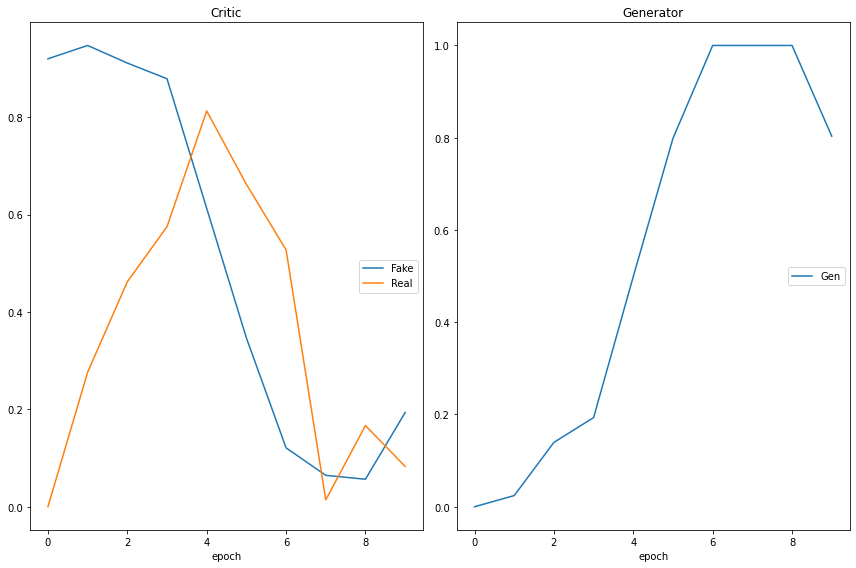

Critic
	Fake             	 (min:    0.056, max:    0.947, cur:    0.194)
	Real             	 (min:    0.000, max:    0.813, cur:    0.083)
Generator
	Gen              	 (min:    0.000, max:    1.000, cur:    0.803)


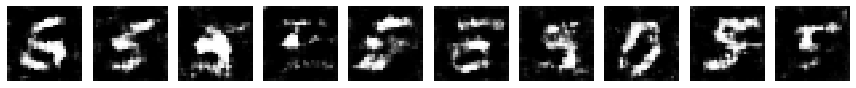

-0.8797447681427002 0.6794323921203613 0.0 0.484375 -0.6182553768157959 -0.023629389703273773


In [ ]:
individual = np.random.random((5))
dcgan = DCGAN(individual)

history = dcgan.train(train_images, verbose=1)

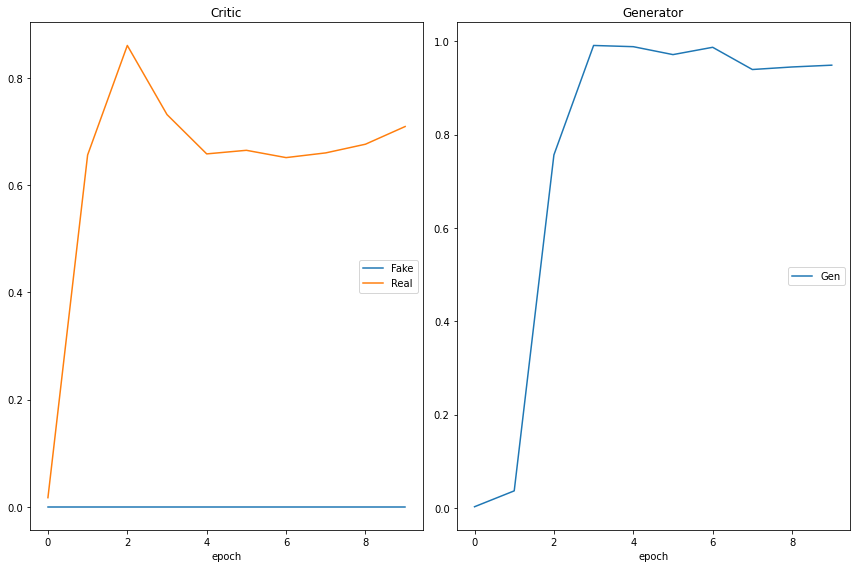

Critic
	Fake             	 (min:    0.000, max:    0.000, cur:    0.000)
	Real             	 (min:    0.017, max:    0.861, cur:    0.710)
Generator
	Gen              	 (min:    0.002, max:    0.991, cur:    0.949)


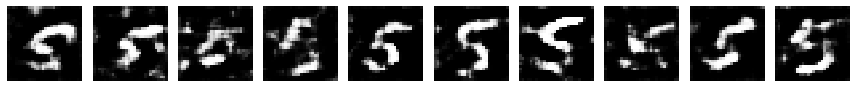

-0.0019175910856574774 -3.621624273364432e-05 0.0 0.0 -0.00028272432973608375 0.00013713020598515868


In [ ]:
individual = np.random.random((10))
individual[FILTERS] = reverse_space(128, MIN_FILTERS, MAX_FILTERS)
individual[ALPHA] = reverse_space(.2, MIN_ALPHA, MAX_ALPHA)
individual[CLIP] = reverse_space(.01, MIN_CLIP, MAX_CLIP)
individual[CRITICS] = reverse_space(5, MIN_CRITICS, MAX_CRITICS)
individual[LR] = reverse_space(.00005, MIN_LR, MAX_LR)
print(individual)

dcgan = DCGAN(individual)
history = dcgan.train(train_images, verbose=1)